## Coin Classification
Here we import all of the necessary libraries and print out an image of the coins to get a feel for the data. This is where we import our cascade classifier which was trained outside of this notebook since it used the opencv cli. The script that I used for training is called data/opencv-haar-classifier-training/script.sh. It is used to create the training data from random images of coins which I took from the Internet. Those images are located at data/opencv-haar-classifier-training/positive_images. Notice how some of the images are not well cropped. This will come into my discussion later. I got the information on how to use opencv from this tutorial: http://coding-robin.de/2013/07/22/train-your-own-opencv-haar-classifier.html. I got the architecture for the cnn from here: https://arxiv.org/pdf/1608.06037.pdf.

Using TensorFlow backend.


There are 2970 total coin images.
data/coins/testing/85_1477852098.jpg


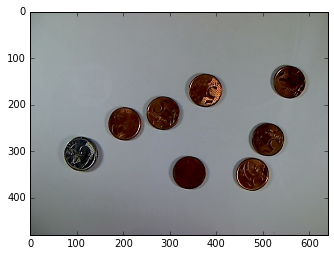

In [1]:
import random
import cv2                
import matplotlib.pyplot as plt
import numpy as np
from glob import glob
from keras.preprocessing import image as img_proc
from keras.backend import tf as ktf
from keras.utils import np_utils
from sklearn.datasets import load_files
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense, BatchNormalization, Activation
from keras.models import Sequential
from keras.callbacks import ModelCheckpoint  

%matplotlib inline
random.seed(8675309)

# load filenames in shuffled human dataset
coin_files = np.array(glob("data/coins/testing/*"))
random.shuffle(coin_files)

# print statistics about the dataset
print('There are %d total coin images.' % len(coin_files))
print coin_files[3]
test_img = cv2.imread(coin_files[3])
rgb_test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)
plt.imshow(rgb_test_img)
plt.show()

## Opencv Testing
Here we print out the same image as above except this time we have used the cascade classifier to determine the locations of the coins in the image. Notice how the boxes drawn around the coins are fairly large compared to the size of the coin. I believe this is because I did not do a very good job cropping the images in the training set for the cascade classifier. Some results below will give us a little better idea of how well this classification works. 

x, y, dx, dy
[[423 296 105 105]
 [ 52 249 110 110]
 [452 221 108 108]
 [501  98 107 107]
 [281 289 117 117]
 [233 166 107 107]
 [147 185 112 112]
 [311 110 113 113]]


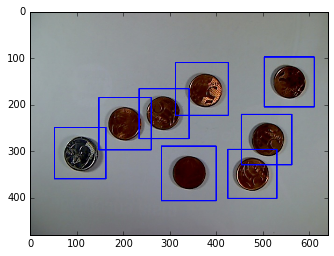

In [2]:
coin_cascade = cv2.CascadeClassifier('data/opencv-haar-classifier-training/classifier/cascade.xml')
grey_test_img = cv2.cvtColor(test_img, cv2.COLOR_BGR2GRAY)
coins = coin_cascade.detectMultiScale(grey_test_img)
print 'x, y, dx, dy'
print coins

for (x,y,w,h) in coins:
    # add bounding box to color image
    cv2.rectangle(test_img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
boxed_coin = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(boxed_coin)
plt.show()


## Architectural Overview
This is where most of the relevant code is. Here we have the code to break each image up into sub images each (hopefully) containing only one coin. These single coin images were then used to train a convolution neural network. The cnn is used to determine the value of each coin: 5, 10, 25, 50, or 100. Only the images which I knew contained a single coin were used to train the cnn. I did this because they were the only single coin images that were prelabeled and thus I knew that their labeled values would correspond to the actual value of the single coin and not a collection of coins. The architecture for the cnn will be discussed in the results discussion. 

In [3]:
# Crop coins out of the larger image. returns a list of single coin images
# retruns a list of images of coins
def crop_image(image_path):
    image = cv2.imread(image_path)
    coin_cascade = cv2.CascadeClassifier('data/opencv-haar-classifier-training/classifier/cascade.xml')
    grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    coin_boxes = coin_cascade.detectMultiScale(grey_image)
    cropped_images = []
    for box in coin_boxes:
        cropped_images.append(image[box[1]:box[1]+box[3],box[0]:box[0]+box[2]])
    return [cv2.cvtColor(image, cv2.COLOR_BGR2RGB) for image in cropped_images]
        
# Convert each image into a (100, 100, 3) tensor for classification by a neural net
def image_to_tensor(image):
    image = cv2.resize(image, (100,100))
    x = img_proc.img_to_array(image)
    return np.expand_dims(x, axis=0)[0].astype('float32')/255

# conveneice function for converting numbers for use in to_catigorical
def convert_numbers(number):
    number = int(number)
    if number == 5:
        return 0
    elif number == 10:
        return 1
    elif number == 25:
        return 2
    elif number == 50:
        return 3
    elif number == 100:
        return 4

# another convenience function
def convert_numbers_back(index):
    index = int(index)
    if index == 0:
        return 5
    elif index == 1:
        return 10
    elif index == 2:
        return 25
    elif index == 3:
        return 50
    elif index == 4:
        return 100    
    
# returns a list of coin files as strings and associated labels as numpy arrays in a RANDOM ORDER
# Note: this only works for training data since it only has one coin in it.
def get_training_image_labels(path):
    training_coin_files = np.array(glob(path + "/*"))
    random.seed(8675309)
    random.shuffle(training_coin_files)
    training_coin_labels = []
    for f in training_coin_files:
        training_coin_labels.append(f.split('/')[-1].split('_')[0])
    training_labels = np_utils.to_categorical([convert_numbers(label) for label in training_coin_labels])
    return training_coin_files, training_labels
    
# returns true if there are multile coins in an image false otherwise    
def check_for_single_coin(path):
    if len(crop_image(path)) == 1:
        return True
    else: 
        return False

# return a  list of tensors and associated labels making sure to only get one coin per image  
# this can take a while
def prepare_training_data(path):
    training_paths, training_labels = get_training_image_labels(path)
    tensors = []
    labels = []
    for i in range(len(training_paths)):
        if i % 200 == 0:
            print "Processing image number: " + str(i)
        if check_for_single_coin(training_paths[i]):
            image = crop_image(training_paths[i])
            tensor = image_to_tensor(image[0])
            tensors.append(tensor)
            labels.append(training_labels[i])
    return np.asarray(tensors), np.asarray(labels)

# returns a trained keras model and the path to the model weights
def train_model(train_tensors, train_targets, valid_tensors, valid_targets, epochs, dropout_rate, initial_filters):
    model = Sequential()
    shape = train_tensors.shape
    model.add(BatchNormalization(input_shape=shape[1:]))
    model.add(Conv2D(filters=initial_filters, kernel_size=3, strides=1))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=initial_filters*2, kernel_size=3, strides=1))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=initial_filters*3, kernel_size=3, strides=1))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=initial_filters*4, kernel_size=3, strides=1))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=initial_filters*5, kernel_size=3, strides=1))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=initial_filters*6, kernel_size=3, strides=1))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=initial_filters*7, kernel_size=1, strides=1))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(filters=initial_filters*8, kernel_size=1, strides=1))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Conv2D(filters=initial_filters*9, kernel_size=3, strides=1))
    model.add(Dropout(dropout_rate))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(len(train_targets[0]), activation="sigmoid"))
    
    model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
    print model.summary()
    checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', save_best_only=True, verbose=1)
    model.fit(train_tensors, train_targets, validation_data=(valid_tensors, valid_targets), batch_size=100, epochs=epochs, callbacks=[checkpointer],  verbose=1)
    return model, 'saved_models/weights.best.from_scratch.hdf5'

## Prepare the Training Data

Here we are running all the images that definitely have only one coin in them and running them through the cascade filter. If the cascade filter determines the image does not have exactly one coin in it we throw out the image. Note that even with this precaution we are unsure that the training data is 100% good. Its very likely that there are at least a few images where the cascade filter draws a single box on the image but not where there is a coin, returning a blank white image. This is not desirable but not easy to rectify without manual intervention. Notice that the number of single coin images that were determined to by the cascade filter to actually contain one coin is about 83% so that is not such a good number when you factor it in with the rest of the errors as I will explain later.

In [4]:
tensors, labels = prepare_training_data('data/coins/training_data/')
print "The total number of single coin images classified as having a single coin is: " + str(len(labels))
print "This is compared to the real number of single coin images which is: 3055 for a total accuracy of: " + str(100*len(labels)/3055.0) + '%.'
train_tensors = tensors[:2100]
train_targets = labels[:2100]
valid_tensors = tensors[2100:]
valid_targets = labels[2100:]
# Note: This image processing can take a WHILE. like maybe hours if your comptuer is not fast

Processing image number: 0
Processing image number: 200
Processing image number: 400
Processing image number: 600
Processing image number: 800
Processing image number: 1000
Processing image number: 1200
Processing image number: 1400
Processing image number: 1600
Processing image number: 1800
Processing image number: 2000
Processing image number: 2200
Processing image number: 2400
Processing image number: 2600
Processing image number: 2800
Processing image number: 3000
The total number of single coin images classified as having a single coin is: 2552
This is compared to the real number of single coin images which is: 3055 for a total accuracy of: 83.535188216%.


## Training the Cnn

Here we're actually training the cnn. Not much more to say about that just yet.

In [5]:
trained_model, model_weights_path = train_model(train_tensors, train_targets, valid_tensors, valid_targets, 100, 0, 50)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 100, 100, 3)       12        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 98, 98, 50)        1400      
_________________________________________________________________
dropout_1 (Dropout)          (None, 98, 98, 50)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 98, 98, 50)        200       
_________________________________________________________________
activation_1 (Activation)    (None, 98, 98, 50)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 96, 96, 100)       45100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 96, 96, 100)       0         
__________

2100/2100 [==============================] - 6s - loss: 0.1044 - acc: 0.9671 - val_loss: 2.4526 - val_acc: 0.4735
Epoch 9/100
2100/2100 [==============================] - 6s - loss: 0.0833 - acc: 0.9714 - val_loss: 2.8921 - val_acc: 0.2412
Epoch 10/100
2100/2100 [==============================] - 6s - loss: 0.0646 - acc: 0.9771 - val_loss: 2.3901 - val_acc: 0.1881
Epoch 11/100
2100/2100 [==============================] - 6s - loss: 0.0743 - acc: 0.9710 - val_loss: 1.2803 - val_acc: 0.4248
Epoch 12/100
2100/2100 [==============================] - 6s - loss: 0.0661 - acc: 0.9738 - val_loss: 0.9709 - val_acc: 0.5686
Epoch 13/100
2100/2100 [==============================] - 6s - loss: 0.0430 - acc: 0.9876 - val_loss: 1.9358 - val_acc: 0.3296
Epoch 14/100
2100/2100 [==============================] - 6s - loss: 0.0316 - acc: 0.9890 - val_loss: 0.9166 - val_acc: 0.6195
Epoch 15/100
2100/2100 [==============================] - 6s - loss: 0.0393 - acc: 0.9848 - val_loss: 1.2077 - val_acc: 0.630

2100/2100 [==============================] - 6s - loss: 0.0026 - acc: 0.9986 - val_loss: 0.0450 - val_acc: 0.9801
Epoch 37/100
2100/2100 [==============================] - 6s - loss: 0.0028 - acc: 0.9986 - val_loss: 0.0405 - val_acc: 0.9823
Epoch 38/100
2100/2100 [==============================] - 6s - loss: 0.0026 - acc: 0.9990 - val_loss: 0.0525 - val_acc: 0.9779
Epoch 39/100
2100/2100 [==============================] - 6s - loss: 0.0026 - acc: 0.9990 - val_loss: 0.0468 - val_acc: 0.9845
Epoch 40/100
2100/2100 [==============================] - 6s - loss: 0.0024 - acc: 0.9990 - val_loss: 0.0428 - val_acc: 0.9867
Epoch 41/100
2100/2100 [==============================] - 6s - loss: 0.0027 - acc: 0.9990 - val_loss: 0.0536 - val_acc: 0.9823
Epoch 42/100
2100/2100 [==============================] - 6s - loss: 0.0024 - acc: 0.9986 - val_loss: 0.0422 - val_acc: 0.9823
Epoch 43/100
2100/2100 [==============================] - 6s - loss: 0.0022 - acc: 0.9986 - val_loss: 0.0389 - val_acc: 0.98

2100/2100 [==============================] - 6s - loss: 0.0026 - acc: 0.9990 - val_loss: 0.0394 - val_acc: 0.9823
Epoch 69/100
2100/2100 [==============================] - 6s - loss: 0.0023 - acc: 0.9990 - val_loss: 0.0440 - val_acc: 0.9801
Epoch 70/100
2100/2100 [==============================] - 6s - loss: 0.0030 - acc: 0.9990 - val_loss: 0.0405 - val_acc: 0.9845
Epoch 71/100
2100/2100 [==============================] - 6s - loss: 0.0033 - acc: 0.9990 - val_loss: 0.0320 - val_acc: 0.9867
Epoch 72/100
2100/2100 [==============================] - 6s - loss: 0.0024 - acc: 0.9995 - val_loss: 0.0490 - val_acc: 0.9801
Epoch 73/100
2100/2100 [==============================] - 6s - loss: 0.0021 - acc: 0.9995 - val_loss: 0.0423 - val_acc: 0.9801
Epoch 74/100
2100/2100 [==============================] - 6s - loss: 0.0017 - acc: 0.9990 - val_loss: 0.0389 - val_acc: 0.9823
Epoch 75/100
2100/2100 [==============================] - 6s - loss: 0.0017 - acc: 0.9990 - val_loss: 0.0361 - val_acc: 0.98

2100/2100 [==============================] - 6s - loss: 0.0190 - acc: 0.9952 - val_loss: 2.0658 - val_acc: 0.7367


## Analysis

I will now explain the results as best I can. From above we know that the opencv cascade classifier is at least as bad as 83%. I say this because I only verified the results on single coin images. I suspect that it does worse on images with more than one coin but I have no way to quantify this without doing manual labor which I'm not really willing to do. Next we have our validation accuracy. This is reported as about 98.6%. This is pretty damn good considering the quality of the data and some of the results that I saw online that were getting about 97%. The final and most interesting accuracy is the total overall accuracy which is about 38%. Now this doesn't sound very good but lets break this down given our architecture choices. 

First we make the assumption that the cascade classifier is actually 83% accurate. Then we take into account that there is a 98% chance of getting each individual coin classified correctly. Then say these are all independent. (They're not really independent. For example if the cascade filter boxes a coin that doesn't exist its going to get a nonzero value assigned to it which is really going to mess things up. But for simplicity we will assume they're independent). Then say there are 10 coins in an image. Then the chance of getting that classified correctly is .83 * .98^10 = .678. So we see that the chance of getting a correct answer goes down significantly with the number of coins. As I said before the cascade filter is AT BEST 83% accurate but probably much worse with pictures with more than one coin. I did not do a very good job cropping the coins for the test data. I also have a suspicion that the model is over trained a bit so we're probably not getting 98% accuracy on each individual coin. The model ran long enough that it could have gotten over fitted to the validation data since we were only saving the weights that performed best on the validation set. 

So, how do we improve this. The first and most obvious answer is we need more training data. We are only training on 2100 images of individual coins and thats not really enough for a cnn to make generalizations. The cnn usually got about 99.9% accuracy on the training data within 50 or so epochs with the validation accuracy lagging behind significantly. I think a legitimate solution to this would be to take all of our training images and rotate them by 90, 180 and 270 degrees, quadrupling our training data. Since coins are round and can appear in the image in any configuration I think this is a valid way to get more data to train the cnn on. Another thing that we should try to do is get the 83% accuracy for the cascade filter up. I think this can be achieved through better quality training data and more of it. I just randomly downloaded coin pictures from the Internet and didn't bother to crop them in any way. I dont really want to take the time to retrain a cascade filter because it took 6 hours on my 16 core 32 thread cpu. If you look at the picture above which has the boxed coins you can see that the box is much larger than the coins. A better cascade filter would work to shrink that. That would help with the overall accuracy of the cnn used to classify the coins. 

I also arbitrarily got the architecture for the neural network from https://arxiv.org/pdf/1608.06037.pdf. I didn't test all the posible parameters for the network nor did I really attempt to make other architectures work. I'm sure there are better methods that would outperform this. For example we might be able to use transfer learning. Or since the number of data points is relatively low it may even be best to not use a neural network at all and just use some sort of classification algorithm such as naive bays or something like that. This type of approach is not well suited for counting large numbers of coins. A use case where this method may be useful would be quality control. For example if you put a high resolution camera above a conveyer belt that has a bunch of nails on it you could inspect each nail and try to visually determine if the nail is defective filtering out the defective nails and letting the good ones pass. 


In [6]:
def count_coins(path, model, model_weights):
    model.load_weights(model_weights)
    coin_list = crop_image(path)
    tensor_list = [image_to_tensor(coin) for coin in coin_list]
    total = 0
    for tensor in tensor_list:
        total = total + convert_numbers_back(np.argmax(model.predict(np.expand_dims(tensor, axis=0))))
    return total
    
    
def test_accuracy(path, model, model_weights):
    actual_value = path.split('/')[-1].split('_')[0]
    if int(actual_value) == int(count_coins(path, model, model_weights)):
        return 1
    else:
        return 0


total_numb_files = len(coin_files)
total = 0
count = 0
for filepath in coin_files:
    count = count + 1
    if count % 100 == 0:
        print "Processing image number: " + str(count)    
    total = total + test_accuracy(filepath, trained_model, model_weights_path)
    
print "Total Accuracy is: " + str(100.0 * float(total)/total_numb_files) + '%'
# 26.3% with 200 epochs and a dropout rate of .2, initial filters=12
# 39.15% with 300 epoch and a dropout rate of 0 inital filters=12
# 40.60% with 100 epochs and a dropout rate of 0 initial filters=50
# Note this image processing can take a WHILE like maybe hours if your comptuer is not fast

Processing image number: 100
Processing image number: 200
Processing image number: 300
Processing image number: 400
Processing image number: 500
Processing image number: 600
Processing image number: 700
Processing image number: 800
Processing image number: 900
Processing image number: 1000
Processing image number: 1100
Processing image number: 1200
Processing image number: 1300
Processing image number: 1400
Processing image number: 1500
Processing image number: 1600
Processing image number: 1700
Processing image number: 1800
Processing image number: 1900
Processing image number: 2000
Processing image number: 2100
Processing image number: 2200
Processing image number: 2300
Processing image number: 2400
Processing image number: 2500
Processing image number: 2600
Processing image number: 2700
Processing image number: 2800
Processing image number: 2900
Total Accuracy is: 38.0471380471%


## Some Testing Functions

Just some cruddy unit testing functions. 

In [7]:
def test_crop_image():
    cropped_images = crop_image(coin_files[3])
    print len(cropped_images[1])
    for image in cropped_images:
        plt.imshow(image)
        plt.show()

def test_image_to_tensor():
    cropped_images = crop_image(coin_files[3])
    print image_to_tensor(cropped_images[0])

def test_get_training_image_labels():
    files, labels = get_training_image_labels('data/coins/training_data/')
    for i in range(5):
        print files[i]
        print labels[i]
        
def test_prepare_training_data():
    tensors, labels = prepare_training_data('data/coins/training_data/')
    print tensors.shape
    print labels.shape
    print tensors[0]
    print labels[0]

In [8]:
#test_crop_image()
#test_image_to_tensor()
#test_get_training_image_labels()
#test_prepare_training_data()
#trained_model = train_model(train_tensors, train_targets, valid_tensors, valid_targets, 1000)